In [3]:
import os
from dataclasses import dataclass
from typing import Dict, Tuple, Optional
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import GroupShuffleSplit
import timm
from pathlib import Path
from PIL import Image
import torchvision.transforms as T

In [ ]:
## Assigning hyperparameters of model such as : learning rate , swintransformer patch and windows number and variant of it and etc :

In [4]:
@dataclass
class Config:
    image_size: int = 224
    batch_size: int = 32
    epochs: int = 25
    # LRs: smaller for pretrained backbone, bigger for fresh heads
    lr_backbone: float = 1e-4
    lr_heads: float = 3e-4
    weight_decay: float = 1e-4
    freeze_backbone_epochs: int = 2
    # task class counts (we'll set dynamically after reading CSV)
    n_brand: int = 4
    n_model: int = 25
    n_year:  int = 12
    # model
    swin_name: str = "swin_tiny_patch4_window7_224"
    # loss mixing across heads
    loss_weights: Tuple[float, float, float] = (1.0, 1.0, 0.3)
    # paths
    csv_path: str = "/content/data.csv"   # <-- change to your CSV
    img_col: str = "path"                 # name of image path column
    brand_col: str = "brand"
    model_col: str = "model"
    year_col:  str = "year"
    # split
    val_ratio: float = 0.15
    seed: int = 123

cfg = Config()
print(cfg)


Config(image_size=224, batch_size=32, epochs=25, lr_backbone=0.0001, lr_heads=0.0003, weight_decay=0.0001, freeze_backbone_epochs=2, n_brand=4, n_model=25, n_year=12, swin_name='swin_tiny_patch4_window7_224', loss_weights=(1.0, 1.0, 0.3), csv_path='/content/data.csv', img_col='path', brand_col='brand', model_col='model', year_col='year', val_ratio=0.15, seed=123)


In [ ]:
##uploading dataset and unzip it :

In [5]:
from google.colab import files
uploaded = files.upload()

Saving dataset.zip to dataset.zip


In [6]:
!unzip dataset.zip -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/Acura_ILX_2020_25_17_200_24_4_70_55_182_24_FWD_5_4_4dr_TRM.jpg  
  inflating: /content/dataset/Acura_ILX_2020_25_17_200_24_4_70_55_182_24_FWD_5_4_4dr_UBV.jpg  
  inflating: /content/dataset/Acura_ILX_2020_25_17_200_24_4_70_55_182_24_FWD_5_4_4dr_UZf.jpg  
  inflating: /content/dataset/Acura_ILX_2020_25_17_200_24_4_70_55_182_24_FWD_5_4_4dr_XMJ.jpg  
  inflating: /content/dataset/Acura_ILX_2020_25_17_200_24_4_70_55_182_24_FWD_5_4_4dr_XuG.jpg  
  inflating: /content/dataset/Acura_ILX_2020_25_17_200_24_4_70_55_182_24_FWD_5_4_4dr_XzS.jpg  
  inflating: /content/dataset/Acura_ILX_2020_25_17_200_24_4_70_55_182_24_FWD_5_4_4dr_yOb.jpg  
  inflating: /content/dataset/Acura_MDX_2011_42_18_300_37_6_78_68_191_16_AWD_7_4_SUV_ARU.jpg  
  inflating: /content/dataset/Acura_MDX_2011_42_18_300_37_6_78_68_191_16_AWD_7_4_SUV_AWZ.jpg  
  inflating: /content/dataset/Acura_MDX_2011_42_18_300_37_6_78_68_191_16_AWD_7_4_SUV_AYx.jpg  

In [7]:
source = Path("/content/dataset")
IMG_EXT = {".jpg",".jpeg"}

In [ ]:
## seperate the label of dataset to form dataframe of brand,model and years of cars with their label and Path :

In [8]:
def parse(p: Path):
  parts = p.stem.split("_")
  brand = parts[0] if len(parts) > 0 else "Unknown"
  model = parts[1]  if len(parts) > 1 else "Unknown"
  year = parts[2]   if len(parts) > 2 and parts[2].isdigit() else "Unknown"
  group = f"{brand}_{model}_{year}"
  return { "brand": brand, "model": model, "year": year, "group": group}

In [9]:
files = [p for p in source.rglob("*") if p.suffix.lower() in IMG_EXT]
df = pd.DataFrame(parse(p) for p in files)
df["source"] = [str(p) for p in files]
print(df.head())

        brand model  year               group  \
0        Audi    Q7  2017        Audi_Q7_2017   
1        Audi    TT  2011        Audi_TT_2011   
2        Audi    A5  2016        Audi_A5_2016   
3        Audi    A5  2010        Audi_A5_2010   
4  Alfa Romeo    4C  2015  Alfa Romeo_4C_2015   

                                              source  
0  /content/dataset/Audi_Q7_2017_49_18_250_20_4_7...  
1  /content/dataset/Audi_TT_2011_38_18_210_20_4_7...  
2  /content/dataset/Audi_A5_2016_47_18_220_20_4_7...  
3  /content/dataset/Audi_A5_2010_44_18_210_20_4_7...  
4  /content/dataset/Alfa Romeo_4C_2015_63_17_230_...  


In [ ]:
##splitting and shuffling of data for training and validation :

In [10]:
split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(split.split(df, groups=df["group"]))

train_df = df.iloc[train_idx].reset_index(drop=True)
val_df   = df.iloc[val_idx].reset_index(drop=True)

print(f"Total: {len(df)} | Train: {len(train_idx)} | Val: {len(val_idx)}")
print(val_df.head())

Total: 5169 | Train: 4251 | Val: 918
        brand model  year               group  \
0  Alfa Romeo    4C  2015  Alfa Romeo_4C_2015   
1        Audi    A6  2020        Audi_A6_2020   
2       Acura   TLX  2019      Acura_TLX_2019   
3       Acura   TLX  2019      Acura_TLX_2019   
4        Audi    A4  2013        Audi_A4_2013   

                                              source  
0  /content/dataset/Alfa Romeo_4C_2015_63_17_230_...  
1  /content/dataset/Audi_A6_2020_54_19_240_20_4_7...  
2  /content/dataset/Acura_TLX_2019_33_17_200_24_4...  
3  /content/dataset/Acura_TLX_2019_33_17_200_24_4...  
4  /content/dataset/Audi_A4_2013_34_17_210_20_4_7...  


In [ ]:
##mapping and labeling features of autos in dataset :

In [11]:
brand2id = {b: i for i, b in enumerate(sorted(train_df["brand"].unique()))}
model2id = {m: i for i, m in enumerate(sorted(train_df["model"].unique()))}
year2id  = {y: i for i, y in enumerate(sorted(train_df["year"].unique()))}

train_df["brand_id"] = train_df["brand"].map(brand2id)
train_df["model_id"] = train_df["model"].map(model2id)
train_df["year_id"]  = train_df["year"].map(year2id)

val_df["brand_id"] = val_df["brand"].map(brand2id)
val_df["model_id"] = val_df["model"].map(model2id)
val_df["year_id"]  = val_df["year"].map(year2id)

n_brand = len(brand2id)
n_model = len(model2id)
n_year  = len(year2id)

print(brand2id)
print(model2id)
print(year2id)

{'Acura': 0, 'Alfa Romeo': 1, 'Aston Martin': 2, 'Audi': 3}
{'4C': 0, '4C Spider': 1, 'A3': 2, 'A4': 3, 'A5': 4, 'A6': 5, 'A7': 6, 'A8': 7, 'DB11': 8, 'DBS': 9, 'Giulia': 10, 'ILX': 11, 'MDX': 12, 'NSX': 13, 'Q3': 14, 'Q5': 15, 'Q7': 16, 'Q8': 17, 'R8': 18, 'RDX': 19, 'RLX': 20, 'Stelvio': 21, 'TLX': 22, 'TT': 23, 'Vanquish': 24, 'Vantage': 25, 'e-tron': 26}
{'2003': 0, '2004': 1, '2005': 2, '2009': 3, '2010': 4, '2011': 5, '2012': 6, '2013': 7, '2014': 8, '2015': 9, '2016': 10, '2017': 11, '2019': 12, '2020': 13}


In [12]:
print(train_df["year_id"].value_counts())
print(train_df["model_id"].value_counts())

year_id
12    737
5     588
11    532
9     426
8     369
6     367
10    349
13    335
4     295
7     193
0      33
1      13
2       9
3       5
Name: count, dtype: int64
model_id
4     353
2     344
23    342
18    301
25    246
3     244
12    230
5     215
7     205
11    176
6     172
16    147
20    147
13    139
15    137
24    133
17    112
10     92
14     79
9      78
22     75
21     68
19     66
0      60
26     40
8      35
1      15
Name: count, dtype: int64


In [ ]:
##plot dataset for year head and understanding negative skewed which causes bias and lower accuracy for year head classifier :

Train year distribution:
year_id
0      33
1      13
2       9
3       5
4     295
5     588
6     367
7     193
8     369
9     426
10    349
11    532
12    737
13    335
Name: count, dtype: int64

Val year distribution:
year_id
1.0       9
2.0      45
5.0      68
6.0     114
7.0     112
8.0      69
9.0      55
10.0     59
11.0    100
12.0    150
13.0    100
Name: count, dtype: int64


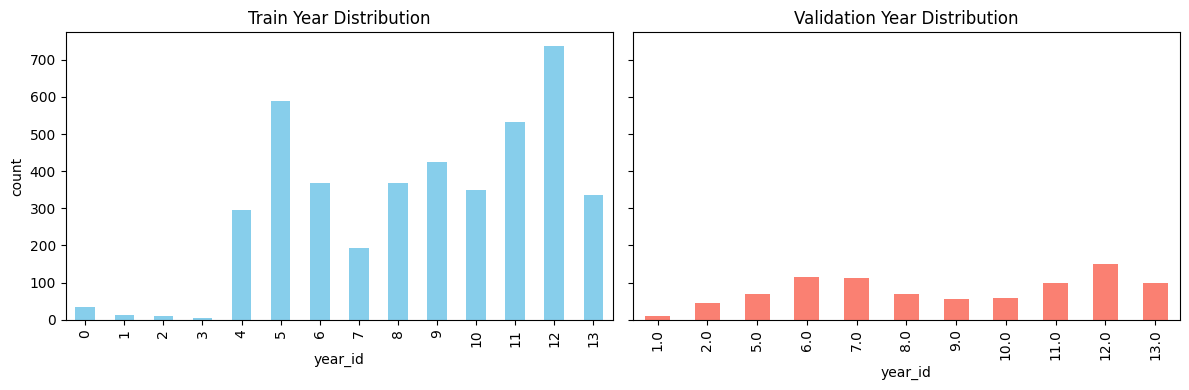

In [13]:
import matplotlib.pyplot as plt

def check_year_distribution(train_df, val_df):
    # count frequencies
    train_counts = train_df["year_id"].value_counts().sort_index()
    val_counts   = val_df["year_id"].value_counts().sort_index()

    print("Train year distribution:")
    print(train_counts)
    print("\nVal year distribution:")
    print(val_counts)

    # plot side by side
    fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    train_counts.plot(kind="bar", ax=ax[0], color="skyblue")
    ax[0].set_title("Train Year Distribution")
    ax[0].set_xlabel("year_id")
    ax[0].set_ylabel("count")

    val_counts.plot(kind="bar", ax=ax[1], color="salmon")
    ax[1].set_title("Validation Year Distribution")
    ax[1].set_xlabel("year_id")

    plt.tight_layout()
    plt.show()

check_year_distribution(train_df, val_df)


In [ ]:
##preprocessing before compiling model as augmentation , filterin NAN data :

In [14]:
# Requirements:
# train_df/val_df must have columns: "source", "brand_id", "model_id", "year_id"

# drop NaNs like you did for TF:
train_df_cleaned = train_df.dropna(subset=["source","brand_id","model_id","year_id"]).reset_index(drop=True)
val_df_cleaned   = val_df.dropna(subset=["source","brand_id","model_id","year_id"]).reset_index(drop=True)

train_tf = T.Compose([
    T.RandomResizedCrop(224, scale=(0.6, 1.0), ratio=(0.9, 1.1)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandAugment(num_ops=2, magnitude=9),   # stronger, generic
    T.RandomGrayscale(p=0.1),
    T.ToTensor(),
    T.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
    T.RandomErasing(p=0.25),                 # cutout-style regularization
])

val_tf = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
])

class DFImageDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        img = Image.open(row["source"]).convert("RGB")
        x = self.transform(img)
        y = {
            "brand": torch.tensor(int(row["brand_id"]), dtype=torch.long),
            "model": torch.tensor(int(row["model_id"]), dtype=torch.long),
            "year":  torch.tensor(int(row["year_id"]),  dtype=torch.long),
        }
        return x, y

train_loader = DataLoader(
    DFImageDataset(train_df_cleaned, train_tf),
    batch_size=32, shuffle=True
)
val_loader   = DataLoader(
    DFImageDataset(val_df_cleaned,   val_tf),
    batch_size=32, shuffle=False
)


In [ ]:
##This section defines a custom PyTorch model that uses a pretrained Swin Transformer backbone from the TIMM library as a shared feature extractor and -
##attaches three separate classification heads (brand, model, year). The model supports freezing and fine-tuning of the backbone for transfer learning.

In [21]:
import timm
import torch.nn as nn

class MultiHeadSwin(nn.Module):
    def __init__(self, swin_name, n_brand, n_model, n_year, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(
            swin_name,
            pretrained=pretrained,
            num_classes=0,
            global_pool='avg',
            drop_path_rate=0.2,   # stochastic depth
            drop_rate=0.0         # (head dropout handled below)
        )
        d = self.backbone.num_features
        self.dropout = nn.Dropout(p=0.3)      # head dropout
        self.brand_head = nn.Linear(d, n_brand)
        self.model_head = nn.Linear(d, n_model)
        self.year_head  = nn.Linear(d, n_year)

    def forward(self, x):
        f = self.backbone(x)
        f = self.dropout(f)
        return {
            "brand": self.brand_head(f),
            "model": self.model_head(f),
            "year":  self.year_head(f),
        }

    def freeze_backbone(self, freeze: bool = True):
        for p in self.backbone.parameters():
            p.requires_grad = not freeze

model = MultiHeadSwin("swin_tiny_patch4_window7_224", n_brand, n_model, n_year, pretrained=True)


In [ ]:
##This section defines the loss functions for each classification head (with label smoothing and class weighting), separates model parameters into backbone and
##head groups for differential learning rates, and sets up the AdamW optimizer along with a cosine annealing scheduler for smooth learning rate decay.

In [22]:
crit_brand = nn.CrossEntropyLoss(label_smoothing=0.1)
crit_model = nn.CrossEntropyLoss(label_smoothing=0.1)

# OPTIONAL: weight YEAR if imbalanced
# compute class weights from train_df (inverse frequency)
year_counts = train_df["year_id"].value_counts().sort_index().to_numpy()
year_weights = (1.0 / (year_counts + 1e-8))
year_weights = torch.tensor(year_weights / year_weights.mean(), dtype=torch.float32)

crit_year  = nn.CrossEntropyLoss(label_smoothing=0.1, weight=year_weights)

# Param groups: smaller LR for pretrained backbone, larger for new heads
backbone_params, head_params = [], []
for name, p in model.named_parameters():
    if not p.requires_grad: continue
    (backbone_params if name.startswith("backbone.") else head_params).append(p)

optimizer = optim.AdamW([
    {"params": backbone_params, "lr": 1e-4},
    {"params": head_params,     "lr": 3e-4},
], weight_decay=5e-2)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)


In [ ]:
##This section defines the full training pipeline, including forward and backward passes, per-epoch metric aggregation, validation evaluation, and model
##checkpointing. The loop alternates between frozen-backbone warm-up and fine-tuning phases while saving the best Swin Transformer multi-head classifier based on validation loss.

In [24]:
def forward_and_loss(images, labels):
    out = model(images)                          # model is on CPU by default
    lb = crit_brand(out["brand"], labels["brand"])
    lm = crit_model(out["model"], labels["model"])
    ly = crit_year( out["year"],  labels["year"])
    loss = lb + lm + ly
    return loss, (lb.item(), lm.item(), ly.item()), out

@torch.no_grad()
def evaluate(loader):
    model.eval()
    tot_loss = tot_lb = tot_lm = tot_ly = 0.0
    tot_ab = tot_am = tot_ay = n = 0

    for x, y in loader:
        # stay on CPU: no moves
        yb, ym, yy = y["brand"], y["model"], y["year"]

        loss, (lb, lm, ly), out = forward_and_loss(x, {"brand": yb, "model": ym, "year": yy})
        pb, pm, py = out["brand"].argmax(1), out["model"].argmax(1), out["year"].argmax(1)

        bs = x.size(0)
        tot_loss += loss.item()*bs
        tot_lb   += lb*bs
        tot_lm   += lm*bs
        tot_ly   += ly*bs
        tot_ab   += (pb == yb).float().sum().item()
        tot_am   += (pm == ym).float().sum().item()
        tot_ay   += (py == yy).float().sum().item()
        n        += bs

    return {
        "loss":       tot_loss / n,
        "brand_loss": tot_lb   / n,
        "model_loss": tot_lm   / n,
        "year_loss":  tot_ly   / n,
        "brand_acc":  tot_ab   / n,
        "model_acc":  tot_am   / n,
        "year_acc":   tot_ay   / n,
    }

best_val = float("inf")

for epoch in range(1, 13):
    model.freeze_backbone(epoch <= 2)   # call on the model
    model.train()

    run = {"loss":0., "lb":0., "lm":0., "ly":0., "ab":0., "am":0., "ay":0., "n":0}

    for x, y in train_loader:
        # CPU-only: keep tensors as-is
        yb, ym, yy = y["brand"], y["model"], y["year"]

        optimizer.zero_grad(set_to_none=True)
        loss, (lb, lm, ly), out = forward_and_loss(x, {"brand": yb, "model": ym, "year": yy})
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        pb, pm, py = out["brand"].argmax(1), out["model"].argmax(1), out["year"].argmax(1)
        bs = x.size(0)
        run["loss"] += loss.item()*bs
        run["lb"]   += lb*bs
        run["lm"]   += lm*bs
        run["ly"]   += ly*bs
        run["ab"]   += (pb==yb).float().sum().item()
        run["am"]   += (pm==ym).float().sum().item()
        run["ay"]   += (py==yy).float().sum().item()
        run["n"]    += bs

    train_metrics = {
        "loss":       run["loss"]/run["n"],
        "brand_loss": run["lb"]/run["n"],
        "model_loss": run["lm"]/run["n"],
        "year_loss":  run["ly"]/run["n"],
        "brand_acc":  run["ab"]/run["n"],
        "model_acc":  run["am"]/run["n"],
        "year_acc":   run["ay"]/run["n"],
    }

    val_metrics = evaluate(val_loader)
    scheduler.step()

    print(f"Epoch {epoch:02d} | train_loss={train_metrics['loss']:.3f} "
          f"(acc b/m/y={train_metrics['brand_acc']:.3f}/{train_metrics['model_acc']:.3f}/{train_metrics['year_acc']:.3f}) | "
          f"val_loss={val_metrics['loss']:.3f} "
          f"(acc b/m/y={val_metrics['brand_acc']:.3f}/{val_metrics['model_acc']:.3f}/{val_metrics['year_acc']:.3f})")

    if val_metrics["loss"] < best_val:
        best_val = val_metrics["loss"]
        torch.save(
            {"state_dict": model.state_dict(),
             "brand2id": brand2id, "model2id": model2id, "year2id": year2id},
            "swin_multihead_best.pth"
        )


Epoch 01 | train_loss=9.063 (acc b/m/y=0.584/0.122/0.006) | val_loss=7.267 (acc b/m/y=0.520/0.107/0.003)
Epoch 02 | train_loss=8.627 (acc b/m/y=0.652/0.187/0.003) | val_loss=7.168 (acc b/m/y=0.539/0.150/0.001)
Epoch 03 | train_loss=8.040 (acc b/m/y=0.750/0.288/0.019) | val_loss=6.722 (acc b/m/y=0.776/0.255/0.002)
Epoch 04 | train_loss=7.267 (acc b/m/y=0.849/0.461/0.046) | val_loss=6.898 (acc b/m/y=0.802/0.271/0.007)
Epoch 05 | train_loss=6.856 (acc b/m/y=0.895/0.557/0.077) | val_loss=7.162 (acc b/m/y=0.871/0.413/0.006)
Epoch 06 | train_loss=6.452 (acc b/m/y=0.921/0.652/0.100) | val_loss=6.383 (acc b/m/y=0.854/0.447/0.025)
Epoch 07 | train_loss=6.146 (acc b/m/y=0.937/0.703/0.122) | val_loss=6.547 (acc b/m/y=0.813/0.452/0.022)
Epoch 08 | train_loss=5.948 (acc b/m/y=0.948/0.749/0.143) | val_loss=6.157 (acc b/m/y=0.869/0.545/0.011)
Epoch 09 | train_loss=5.723 (acc b/m/y=0.961/0.787/0.164) | val_loss=6.664 (acc b/m/y=0.862/0.533/0.020)
Epoch 10 | train_loss=5.564 (acc b/m/y=0.961/0.823/0.18